# **Estratificacion del dengue en el departamento del Cauca, Colombia**

En este proyecto, trabajaremos con los siguientes datasets

- `entomologico.csv` : Contiene registros de muestras de insectos recolectados en diferentes localidades del departamento del Cauca, en donde cada registro tiene informacion sobre el numero de individuos, genero, especie, fecha y lugar de recoleccion.

In [14]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

plt.style.use('ggplot')

In [15]:
df = pd.read_csv('../data/entomologico.csv')

## **Análisis de diversidad de especies**

###  **Cantidad de registros por especie**

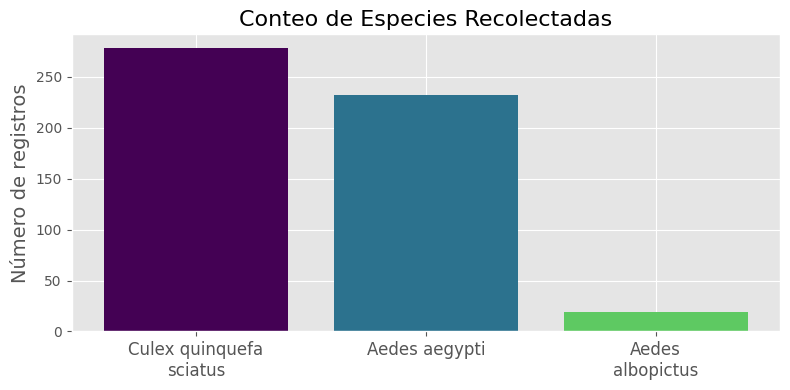


Distribución de especies:


,scientificName,Cantidad,Porcentaje
0,Culex quinquefasciatus,278,52.55
1,Aedes aegypti,232,43.86
2,Aedes albopictus,19,3.59


In [16]:
sc = df['scientificName'].value_counts()
fig, ax = plt.subplots(figsize=(8, 4))
bars = ax.bar(sc.index, sc.values, color=plt.cm.viridis(np.linspace(0, 0.75, len(sc))))

ax.set_title('Conteo de Especies Recolectadas', fontsize=16)
ax.set_ylabel('Número de registros', fontsize=14)

from textwrap import wrap
labels = ['\n'.join(wrap(l, 15)) for l in sc.index]

ax.set_xticks(range(len(sc.index)))
ax.set_xticklabels(labels, rotation=0, fontsize=12)

plt.subplots_adjust(bottom=0.3)
plt.tight_layout()
plt.show()

# Mostrar tabla con porcentajes
sc_percent = pd.DataFrame({
    'Cantidad': sc.values,
    'Porcentaje': np.round((sc.values / sc.values.sum()) * 100, 2)
}, index=sc.index).sort_values('Cantidad', ascending=False).reset_index()

print('\nDistribución de especies:')
display(sc_percent)

###  **Indice de Shannon y Simpson**

El indice de Shannon es una medida estadistica utilizada para cuantificar la diversidad y riqueza de especies en un habitat. Este indice toma en cuenta no solo la cantidad de especies presentes, sino tambien la equidad en su distribucion, lo que ofrece una vision detallada de la biodiversidad de un ecosistema. Por otro lado, el indice de Simspon es una medida aritmetica ponderada que mide la probabilidad de que dos individuos seleccionados aleatoriamente de una muestra pertenezcan a la misma especie.

In [17]:
import re

location_diversity = df.groupby('locality').agg({
    'individualCount': 'sum',
    'scientificName': pd.Series.nunique
}).reset_index().rename(columns={
    'individualCount': 'Total de individuos',
    'scientificName': 'Especies únicas',
})

location_diversity['locality'] = location_diversity['locality'].str.replace(
    r'^Casa ubicada en el barrio (.+) de (.+)$', r'\1 (\2)',
    regex=True
)

diversity_indices = []

for location in df['locality'].unique():
    location_data = df[df['locality'] == location]
    species_counts = location_data.groupby('scientificName')['individualCount'].sum()
    total = species_counts.sum()
    
    # indice de shanon
    shannon = -np.sum((species_counts / total) * np.log(species_counts / total))
    
    # indice de simpson
    simpson = 1 - np.sum((species_counts / total)**2)
    
    diversity_indices.append({
        'Localidad': re.sub(
            r'^Casa ubicada en el barrio (.+) de (.+)$', 
            r'\1 (\2)', 
            location
        ),
        'Indice de Shannon': shannon,
        'Indice de Simpson': simpson,
        'Conteo de especies': len(species_counts),
        'Total de especies': total
    })
    
dff = pd.DataFrame(diversity_indices)
dff['Indice de Shannon'] = dff['Indice de Shannon'].round(2).astype(str)
dff['Indice de Simpson'] = dff['Indice de Simpson'].round(2).astype(str)

sdff = (
    dff.style.set_properties(
        **{"padding": "8px", "border": "1px solid #ddd", "text-align": "center"}
    )
    .set_table_styles(
        [
            {
                "selector": "th",
                "props": [
                    ("padding", "8px"),
                    ("background-color", "#222d32"),
                    ("text-align", "center"),
                    ("font-weight", "bold"),
                ],
            },
            {
                "selector": "caption",
                "props": [
                    ("caption-side", "top"),
                    ("font-size", "16px"),
                    ("font-weight", "bold"),
                ],
            },
        ]
    )
)


display(sdff)


,Localidad,Indice de Shannon,Indice de Simpson,Conteo de especies,Total de especies
0,Puerto Nuevo (Patía (El Bordo)),0.53,0.29,3,82
1,Olaya Herrera (Patía (El Bordo)),0.65,0.39,3,494
2,Balboita (Patía (El Bordo)),0.65,0.38,3,29
3,Fundadores (Patía (El Bordo)),0.51,0.33,2,91
4,Postobón (Patía (El Bordo)),0.24,0.1,3,223
5,Hueco Lindo (Patía (El Bordo)),0.46,0.28,2,41
6,Popular (Patía (El Bordo)),0.47,0.3,2,139
7,Libertador (Patía (El Bordo)),0.68,0.4,3,57
8,Colseguros (Miranda),0.55,0.36,2,25
9,Porvenir (Miranda),0.68,0.49,2,49


### **Visualización de índices de diversidad por barrio**

A continuación se presenta un gráfico comparativo de los índices de Shannon y Simpson para cada barrio estudiado, lo que permite identificar fácilmente las áreas con mayor diversidad de especies.

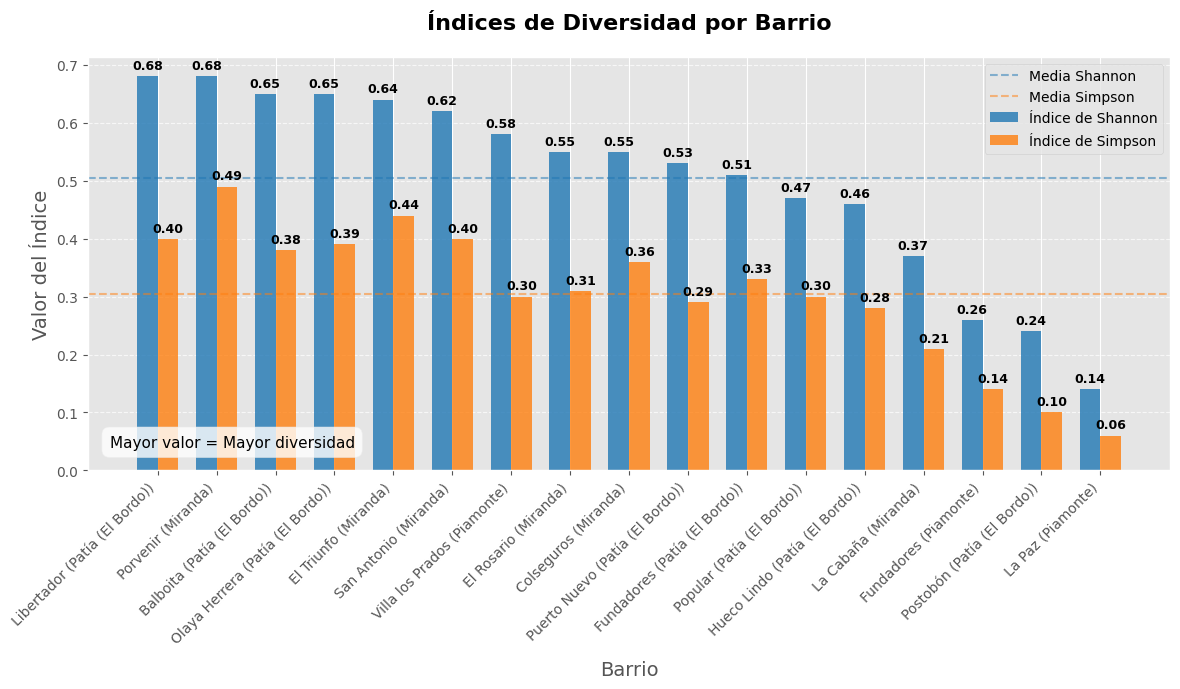

In [18]:
# Convertir los índices de string a float para la visualización
dff_plot = dff.copy()
dff_plot['Indice de Shannon'] = dff_plot['Indice de Shannon'].astype(float)
dff_plot['Indice de Simpson'] = dff_plot['Indice de Simpson'].astype(float)

# Ordenar por índice de Shannon para mejor visualización
dff_plot = dff_plot.sort_values('Indice de Shannon', ascending=False)

# Crear el gráfico de barras agrupadas
fig, ax = plt.subplots(figsize=(12, 7))

# Definir posiciones para las barras
x = np.arange(len(dff_plot['Localidad']))
width = 0.35

# Crear barras para cada índice
shannon_bars = ax.bar(x - width/2, dff_plot['Indice de Shannon'], width, label='Índice de Shannon', 
    color='#1f77b4', alpha=0.8)
simpson_bars = ax.bar(x + width/2, dff_plot['Indice de Simpson'], width, label='Índice de Simpson', 
    color='#ff7f0e', alpha=0.8)

# Añadir etiquetas, título y leyenda
ax.set_title('Índices de Diversidad por Barrio', fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Barrio', fontsize=14, labelpad=10)
ax.set_ylabel('Valor del Índice', fontsize=14)
ax.set_xticks(x)

# Ajustar etiquetas de ejes para mejor legibilidad
ax.set_xticklabels(dff_plot['Localidad'], rotation=45, ha='right', fontsize=10)

# Añadir los valores sobre cada barra
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
            xy=(bar.get_x() + bar.get_width() / 2, height),
            xytext=(0, 3),  # 3 puntos de desplazamiento vertical
            textcoords="offset points",
            ha='center', va='bottom',
            fontsize=9, fontweight='bold')

add_labels(shannon_bars)
add_labels(simpson_bars)

# Añadir una línea horizontal para facilitar comparación visual
ax.axhline(y=dff_plot['Indice de Shannon'].mean(), color='#1f77b4', linestyle='--', alpha=0.5, 
    label='Media Shannon')
ax.axhline(y=dff_plot['Indice de Simpson'].mean(), color='#ff7f0e', linestyle='--', alpha=0.5,
    label='Media Simpson')

# Añadir anotaciones explicativas
# Añadir una anotación explicativa en la esquina inferior derecha
ax.text(0.02, 0.05, 'Mayor valor = Mayor diversidad', transform=ax.transAxes, 
    fontsize=11, va='bottom', ha='left', 
    bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8))

ax.legend(loc='upper right')
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Ajustar diseño
plt.tight_layout()
plt.show()

### **Análisis de distribución geográfica detallada**

In [19]:
# Preparar datos de distribución geográfica
geo_distribution = df.groupby(['decimalLatitude', 'decimalLongitude']).agg({
    'individualCount': 'sum',
    'scientificName': 'nunique'
}).reset_index().rename(columns={'scientificName': 'species_count'})

display(geo_distribution)

,decimalLatitude,decimalLongitude,individualCount,species_count
0,1.112500,-76.323770,1,1
1,1.112719,-76.323765,3,2
2,1.112867,-76.323877,4,1
3,1.112887,-76.323821,5,1
4,1.112921,-76.324925,3,1
...,...,...,...,...
429,3.260109,-76.228073,1,1
430,3.260136,-76.229231,1,1
431,3.260143,-76.232152,1,1
432,3.260237,-76.228626,1,1


<Figure size 1000x800 with 0 Axes>

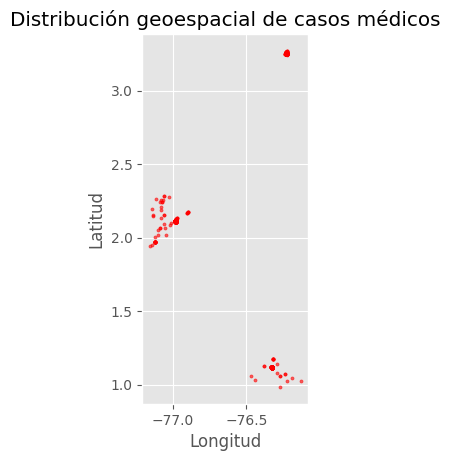

In [20]:
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

cases_df = pd.read_csv('../data/cases.csv')

cases_gdf = gpd.GeoDataFrame(cases_df, geometry=gpd.points_from_xy(cases_df.Longitud, cases_df.Latitud))

# Plotting the geospatial distribution of cases (scatter plot on a map)
plt.figure(figsize=(10, 8))
cases_gdf.plot(marker='o', color='red', markersize=5, alpha=0.6)
plt.title('Distribución geoespacial de casos médicos')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.show()

La gráfica muestra la distribución geoespacial de los casos médicos, representados por puntos en un plano de latitud y longitud. Cada punto indica una ubicación donde se ha registrado un caso médico.

Interpretación:

- Los puntos rojos representan los casos georreferenciados, y su dispersión en el gráfico indica la ubicación de estos casos en un área geográfica específica (en este caso, parece estar centrada en un sector de Colombia).

- La concentración de puntos en ciertas áreas puede indicar una mayor incidencia de casos en esas regiones.

- Las áreas con pocos o ningún punto pueden reflejar lugares donde los casos son menos frecuentes o donde no se han registrado datos.

Esta información puede ser útil para identificar áreas de alta incidencia, lo que permitiría priorizar intervenciones, recursos médicos o campañas de prevención.

In [21]:
cases_df.head()

,OBJECTID,Loc_name,Longitud,Latitud,Proceso,Match_addr,Barrio_OSM,Sexo,Edad,Ocupación,Pertenencia etnica,fec_consulta,ini_sintomas,locationID,county
0,117,La Paz,-76.329537,1.119479,Georreferenciado,Nombre del Barrio,La Paz,M,11,9999,6,2018-01-24 00:00:00,2018-01-24 00:00:00,CO:19533,Piamonte
1,114,Vereda Trojayaco,-76.273166,0.984080,Georreferenciado,Nombre del Centro Poblado,Trojayaco,M,40,6112,1,2016-01-10 00:00:00,2016-01-07 00:00:00,CO:19533,Piamonte
2,123,Villa Los Prados,-76.327719,1.119409,Georreferenciado,Nombre del Barrio,Villa Los Prados,M,4,9999,6,2018-02-09 00:00:00,2018-02-08 00:00:00,CO:19533,Piamonte
3,116,La Paz,-76.329537,1.119479,Georreferenciado,Nombre del Barrio,La Paz,F,14,9999,6,2018-02-14 00:00:00,2018-02-10 00:00:00,CO:19533,Piamonte
4,133,Villa Los Prados,-76.327719,1.119409,Georreferenciado,Nombre del Barrio,Villa Los Prados,M,7,9999,6,2018-02-09 00:00:00,2018-02-07 00:00:00,CO:19533,Piamonte


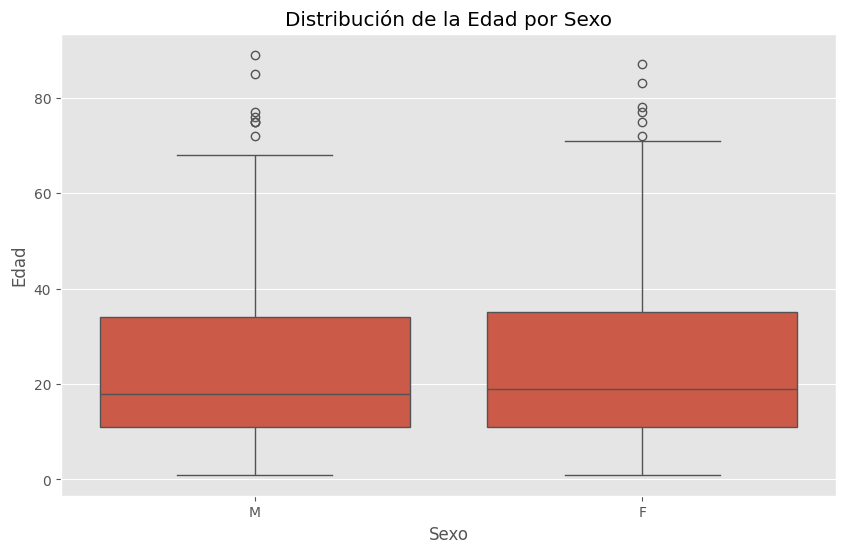

In [22]:

# Analyzing demographic distribution: Age vs Gender
plt.figure(figsize=(10, 6))
sns.boxplot(data=cases_df, x='Sexo', y='Edad')
plt.title('Distribución de la Edad por Sexo')
plt.xlabel('Sexo')
plt.ylabel('Edad')
plt.show()

Number of records with valid dates: 572 out of 573


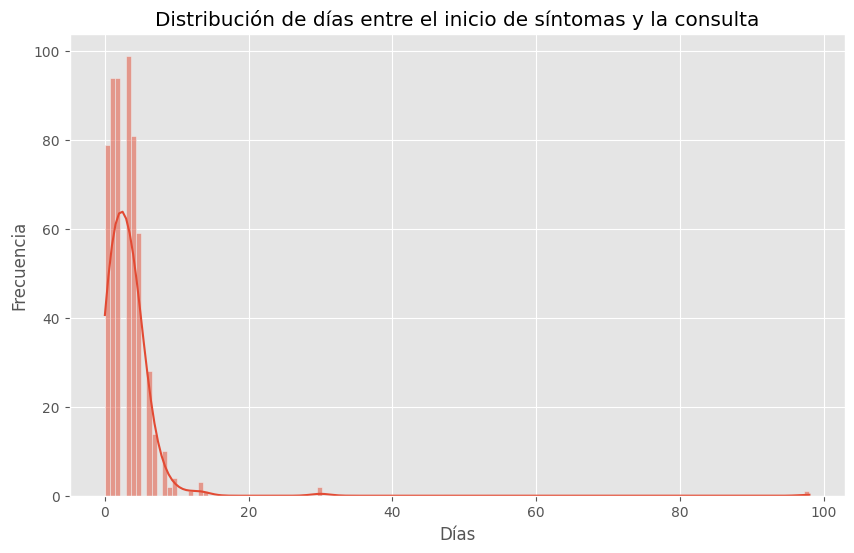

In [23]:

# Temporal analysis: Time between symptoms and consultation (for potential patterns)
# Convert date columns to datetime with error handling
cases_df['fec_consulta'] = pd.to_datetime(cases_df['fec_consulta'], errors='coerce')
cases_df['ini_sintomas'] = pd.to_datetime(cases_df['ini_sintomas'], errors='coerce')

# Drop rows with invalid dates for the temporal analysis
valid_dates = cases_df.dropna(subset=['fec_consulta', 'ini_sintomas'])
print(f"Number of records with valid dates: {len(valid_dates)} out of {len(cases_df)}")
cases_df['ini_sintomas'] = pd.to_datetime(cases_df['ini_sintomas'])
cases_df['days_between_symptoms_and_consultation'] = (cases_df['fec_consulta'] - cases_df['ini_sintomas']).dt.days

# Plotting the distribution of days between symptoms and consultation
plt.figure(figsize=(10, 6))
sns.histplot(cases_df['days_between_symptoms_and_consultation'], kde=True)
plt.title('Distribución de días entre el inicio de síntomas y la consulta')
plt.xlabel('Días')
plt.ylabel('Frecuencia')
plt.show()

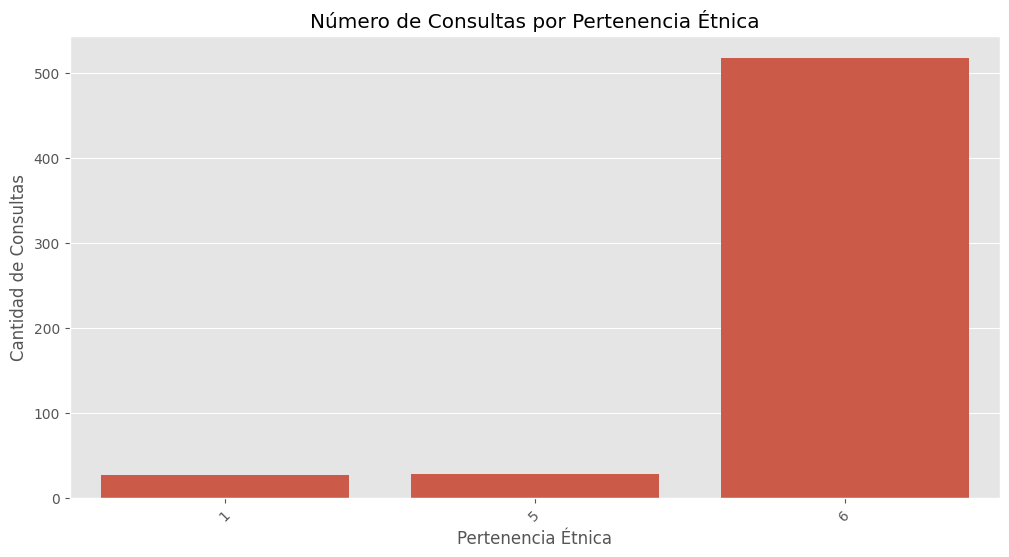

In [24]:


# Correlation between ethnicity and number of consultations
ethnicity_consults = cases_df.groupby('Pertenencia etnica')['OBJECTID'].count().reset_index()
ethnicity_consults.columns = ['Pertenencia etnica', 'Cantidad de Consultas']

# Plotting the correlation between ethnicity and number of consultations
plt.figure(figsize=(12, 6))
sns.barplot(x='Pertenencia etnica', y='Cantidad de Consultas', data=ethnicity_consults)
plt.title('Número de Consultas por Pertenencia Étnica')
plt.xlabel('Pertenencia Étnica')
plt.ylabel('Cantidad de Consultas')
plt.xticks(rotation=45)
plt.show()

In [25]:
# import geopandas as gpd
# import osmnx as ox
# from shapely.geometry import Point, Polygon
# import hvplot.pandas

# # Define the place query
# query = {'city': 'Patia'}

# # Get the boundaries of the place
# try:
#     # Try the newer OSMnx API
#     boundaries = ox.geocode_to_gdf(query)
#     # Add buffer if needed using GeoDataFrame method
#     boundaries['geometry'] = boundaries['geometry'].buffer(0.05)  # ~5km buffer in degrees
# except TypeError:
#     # Fallback method if buffer_dist isn't supported
#     place = ox.geocode_to_gdf(query)
#     # Create buffer manually
#     boundaries = place.copy()
#     boundaries['geometry'] = place['geometry'].buffer(0.05)  # ~5km buffer in degrees

# # Let's check the boundaries on a map
# ax = boundaries.explore(color='red', alpha=0.5)

# boundaries.explore()

In [26]:


# # Create point geometry from coordinates
# df["geometry"] = gpd.points_from_xy(df["decimalLongitude"], df["decimalLatitude"])
# df = gpd.GeoDataFrame(df, crs="epsg:4326")

# # Plot the points on the same map
# df.explore(m=ax, column='scientificName', categorical=True, 
#            legend=True, marker_kwds={'radius': 5})

# # Filter geographically - spatial join with boundaries
# entomological_df = gpd.sjoin(df, boundaries[["geometry"]], predicate='within')
# entomological_df = entomological_df.reset_index(drop=True)

# # Alternative filtering by county name if spatial join doesn't work well
# # entomological_df = df[df['county'] == 'Patía']

# entomological_df.hvplot(geo=True, tiles="OSM", alpha=0.5, width=600, height=600, hover_cols=["name"])